<a href="https://colab.research.google.com/github/JoshuaShunk/NSDropout/blob/main/mnist_implementation_of_Dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Numbers Implementation of My New Layer

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import random
import keras
from keras.datasets import mnist
import tensorflow as tf
import pandas as pd

In [28]:
np.set_printoptions(threshold=np.inf)

In [29]:
np.random.seed(seed=22) #Random seed used for comparison between old dropout

In [30]:
print(np.random.random(size=3)) #Check that seeds line up

[0.20846054 0.48168106 0.42053804]


In [31]:
#@title Load Layers (Credit to Harrison Kinsley & Daniel Kukiela for raw python implementation)

# Dense layer
class Layer_Dense:

    # Layer initialization
    def __init__(self, n_inputs, n_neurons,
                 weight_regularizer_l1=0, weight_regularizer_l2=0,
                 bias_regularizer_l1=0, bias_regularizer_l2=0):
        # Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        # Set regularization strength
        self.weight_regularizer_l1 = weight_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.bias_regularizer_l2 = bias_regularizer_l2

    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs, weights and biases
        self.output = np.dot(inputs, self.weights) + self.biases

    # Backward pass
    def backward(self, dvalues):
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)

        # Gradients on regularization
        # L1 on weights
        if self.weight_regularizer_l1 > 0:
            dL1 = np.ones_like(self.weights)
            dL1[self.weights < 0] = -1
            self.dweights += self.weight_regularizer_l1 * dL1
        # L2 on weights
        if self.weight_regularizer_l2 > 0:
            self.dweights += 2 * self.weight_regularizer_l2 * \
                             self.weights
        # L1 on biases
        if self.bias_regularizer_l1 > 0:
            dL1 = np.ones_like(self.biases)
            dL1[self.biases < 0] = -1
            self.dbiases += self.bias_regularizer_l1 * dL1
        # L2 on biases
        if self.bias_regularizer_l2 > 0:
            self.dbiases += 2 * self.bias_regularizer_l2 * \
                            self.biases

        # Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)

# ReLU activation


class Activation_ReLU:

    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs
        self.output = np.maximum(0, inputs)

    # Backward pass
    def backward(self, dvalues):
        # Since we need to modify original variable,
        # let's make a copy of values first
        self.dinputs = dvalues.copy()

        # Zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0


# Softmax activation
class Activation_Softmax:

    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs

        # Get unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1,
                                            keepdims=True))
        # Normalize them for each sample
        probabilities = exp_values / np.sum(exp_values, axis=1,
                                            keepdims=True)

        self.output = probabilities

    # Backward pass
    def backward(self, dvalues):
        # Create uninitialized array
        self.dinputs = np.empty_like(dvalues)

        # Enumerate outputs and gradients
        for index, (single_output, single_dvalues) in \
                enumerate(zip(self.output, dvalues)):
            # Flatten output array
            single_output = single_output.reshape(-1, 1)

            # Calculate Jacobian matrix of the output
            jacobian_matrix = np.diagflat(single_output) - \
                              np.dot(single_output, single_output.T)
            # Calculate sample-wise gradient
            # and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix,
                                         single_dvalues)
    def predictions(self, outputs):
        return np.argmax(outputs, axis=1)


# Sigmoid activation
class Activation_Sigmoid:

    # Forward pass
    def forward(self, inputs):
        # Save input and calculate/save output
        # of the sigmoid function
        self.inputs = inputs
        self.output = 1 / (1 + np.exp(-inputs))

    # Backward pass
    def backward(self, dvalues):
        # Derivative - calculates from output of the sigmoid function
        self.dinputs = dvalues * (1 - self.output) * self.output


# SGD optimizer
class Optimizer_SGD:

    # Initialize optimizer - set settings,
    # learning rate of 1. is default for this optimizer
    def __init__(self, learning_rate=1., decay=0., momentum=0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                                         (1. / (1. + self.decay * self.iterations))

    # Update parameters

    def update_params(self, layer):

        # If we use momentum
        if self.momentum:

            # If layer does not contain momentum arrays, create them
            # filled with zeros
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                # If there is no momentum array for weights
                # The array doesn't exist for biases yet either.
                layer.bias_momentums = np.zeros_like(layer.biases)

            # Build weight updates with momentum - take previous
            # updates multiplied by retain factor and update with
            # current gradients
            weight_updates = \
                self.momentum * layer.weight_momentums - \
                self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates

            # Build bias updates
            bias_updates = \
                self.momentum * layer.bias_momentums - \
                self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates

        # Vanilla SGD updates (as before momentum update)
        else:
            weight_updates = -self.current_learning_rate * \
                             layer.dweights
            bias_updates = -self.current_learning_rate * \
                           layer.dbiases

        # Update weights and biases using either
        # vanilla or momentum updates
        layer.weights += weight_updates
        layer.biases += bias_updates

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1


# Adagrad optimizer
class Optimizer_Adagrad:

    # Initialize optimizer - set settings
    def __init__(self, learning_rate=1., decay=0., epsilon=1e-7):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                                         (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):

        # If layer does not contain cache arrays,
        # create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update cache with squared current gradients
        layer.weight_cache += layer.dweights ** 2
        layer.bias_cache += layer.dbiases ** 2

        # Vanilla SGD parameter update + normalization
        # with square rooted cache
        layer.weights += -self.current_learning_rate * \
                         layer.dweights / \
                         (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * \
                        layer.dbiases / \
                        (np.sqrt(layer.bias_cache) + self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1


# RMSprop optimizer
class Optimizer_RMSprop:

    # Initialize optimizer - set settings
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7,
                 rho=0.9):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.rho = rho

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                                         (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):

        # If layer does not contain cache arrays,
        # create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update cache with squared current gradients
        layer.weight_cache = self.rho * layer.weight_cache + \
                             (1 - self.rho) * layer.dweights ** 2
        layer.bias_cache = self.rho * layer.bias_cache + \
                           (1 - self.rho) * layer.dbiases ** 2

        # Vanilla SGD parameter update + normalization
        # with square rooted cache
        layer.weights += -self.current_learning_rate * \
                         layer.dweights / \
                         (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * \
                        layer.dbiases / \
                        (np.sqrt(layer.bias_cache) + self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1


# Adam optimizer
class Optimizer_Adam:

    # Initialize optimizer - set settings
    def __init__(self, learning_rate=0.02, decay=0., epsilon=1e-7,
                 beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                                         (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):

        # If layer does not contain cache arrays,
        # create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update momentum  with current gradients
        layer.weight_momentums = self.beta_1 * \
                                 layer.weight_momentums + \
                                 (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * \
                               layer.bias_momentums + \
                               (1 - self.beta_1) * layer.dbiases
        # Get corrected momentum
        # self.iteration is 0 at first pass
        # and we need to start with 1 here
        weight_momentums_corrected = layer.weight_momentums / \
                                     (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / \
                                   (1 - self.beta_1 ** (self.iterations + 1))
        # Update cache with squared current gradients
        layer.weight_cache = self.beta_2 * layer.weight_cache + \
                             (1 - self.beta_2) * layer.dweights ** 2
        layer.bias_cache = self.beta_2 * layer.bias_cache + \
                           (1 - self.beta_2) * layer.dbiases ** 2
        # Get corrected cache
        weight_cache_corrected = layer.weight_cache / \
                                 (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / \
                               (1 - self.beta_2 ** (self.iterations + 1))

        # Vanilla SGD parameter update + normalization
        # with square rooted cache
        layer.weights += -self.current_learning_rate * \
                         weight_momentums_corrected / \
                         (np.sqrt(weight_cache_corrected) +
                          self.epsilon)
        layer.biases += -self.current_learning_rate * \
                        bias_momentums_corrected / \
                        (np.sqrt(bias_cache_corrected) +
                         self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1


# Common loss class
class Loss:


    # Regularization loss calculation
    def regularization_loss(self, layer):

        # 0 by default
        regularization_loss = 0

        # L1 regularization - weights
        # calculate only when factor greater than 0
        if layer.weight_regularizer_l1 > 0:
            regularization_loss += layer.weight_regularizer_l1 * \
                                   np.sum(np.abs(layer.weights))

        # L2 regularization - weights
        if layer.weight_regularizer_l2 > 0:
            regularization_loss += layer.weight_regularizer_l2 * \
                                   np.sum(layer.weights *
                                          layer.weights)

        # L1 regularization - biases
        # calculate only when factor greater than 0
        if layer.bias_regularizer_l1 > 0:
            regularization_loss += layer.bias_regularizer_l1 * \
                                   np.sum(np.abs(layer.biases))

        # L2 regularization - biases
        if layer.bias_regularizer_l2 > 0:
            regularization_loss += layer.bias_regularizer_l2 * \
                                   np.sum(layer.biases *
                                          layer.biases)

        return regularization_loss


    # Set/remember trainable layers
    def remember_trainable_layers(self, trainable_layers):
        self.trainable_layers = trainable_layers

    # Calculates the data and regularization losses
    # given model output and ground truth values
    def calculate(self, output, y, *, include_regularization=False):

        # Calculate sample losses
        sample_losses = self.forward(output, y)

        # Calculate mean loss
        data_loss = np.mean(sample_losses)

        # Return loss
        return data_loss

    # Calculates accumulated loss
    def calculate_accumulated(self, *, include_regularization=False):

        # Calculate mean loss
        data_loss = self.accumulated_sum / self.accumulated_count

        # If just data loss - return it
        if not include_regularization:
            return data_loss

        # Return the data and regularization losses
        return data_loss, self.regularization_loss()

    # Reset variables for accumulated loss
    def new_pass(self):
        self.accumulated_sum = 0
        self.accumulated_count = 0


# Cross-entropy loss
class Loss_CategoricalCrossentropy(Loss):

        # Forward pass
    def forward(self, y_pred, y_true):

        # Number of samples in a batch
        samples = len(y_pred)

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # Probabilities for target values -
        # only if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[
                range(samples),
                y_true
            ]

        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(
                y_pred_clipped * y_true,
                axis=1
            )

        # Losses
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods


    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)
        # Number of labels in every sample
        # We'll use the first sample to count them
        labels = len(dvalues[0])

        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        # Calculate gradient
        self.dinputs = -y_true / dvalues
        # Normalize gradient
        self.dinputs = self.dinputs / samples


# Softmax classifier - combined Softmax activation
# and cross-entropy loss for faster backward step
class Activation_Softmax_Loss_CategoricalCrossentropy():

    # Creates activation and loss function objects
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()

    # Forward pass
    def forward(self, inputs, y_true):
        # Output layer's activation function
        self.activation.forward(inputs)
        # Set the output
        self.output = self.activation.output
        # Calculate and return loss value
        return self.loss.calculate(self.output, y_true)

    # Backward pass
    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)

        # If labels are one-hot encoded,
        # turn them into discrete values
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)

        # Copy so we can safely modify
        self.dinputs = dvalues.copy()
        # Calculate gradient
        self.dinputs[range(samples), y_true] -= 1
        # Normalize gradient
        self.dinputs = self.dinputs / samples


# Binary cross-entropy loss
class Loss_BinaryCrossentropy(Loss):

    # Forward pass
    def forward(self, y_pred, y_true):
        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # Calculate sample-wise loss
        sample_losses = -(y_true * np.log(y_pred_clipped) +
                          (1 - y_true) * np.log(1 - y_pred_clipped))
        sample_losses = np.mean(sample_losses, axis=-1)

        # Return losses
        return sample_losses

    # Backward pass
    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)
        # Number of outputs in every sample
        # We'll use the first sample to count them
        outputs = len(dvalues[0])

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        clipped_dvalues = np.clip(dvalues, 1e-7, 1 - 1e-7)

        # Calculate gradient
        self.dinputs = -(y_true / clipped_dvalues -
                         (1 - y_true) / (1 - clipped_dvalues)) / outputs
        # Normalize gradient
        self.dinputs = self.dinputs / samples

# Common accuracy class
class Accuracy:

    # Calculates an accuracy
    # given predictions and ground truth values
    def calculate(self, predictions, y):

        # Get comparison results
        comparisons = self.compare(predictions, y)

        # Calculate an accuracy
        accuracy = np.mean(comparisons)

        # Add accumulated sum of matching values and sample count
        # Return accuracy
        return accuracy

    # Calculates accumulated accuracy
    def calculate_accumulated(self):

        # Calculate an accuracy
        accuracy = self.accumulated_sum / self.accumulated_count

        # Return the data and regularization losses
        return accuracy

    # Reset variables for accumulated accuracy
    def new_pass(self):
        self.accumulated_sum = 0
        self.accumulated_count = 0


# Accuracy calculation for classification model
class Accuracy_Categorical(Accuracy):

    def __init__(self, *, binary=False):
        # Binary mode?
        self.binary = binary

    # No initialization is needed
    def init(self, y):
        pass

    # Compares predictions to the ground truth values
    def compare(self, predictions, y):
        if not self.binary and len(y.shape) == 2:
            y = np.argmax(y, axis=1)
        return predictions == y


# Accuracy calculation for regression model
class Accuracy_Regression(Accuracy):

    def __init__(self):
        # Create precision property
        self.precision = None

    # Calculates precision value
    # based on passed-in ground truth values
    def init(self, y, reinit=False):
        if self.precision is None or reinit:
            self.precision = np.std(y) / 250

    # Compares predictions to the ground truth values
    def compare(self, predictions, y):
        return np.absolute(predictions - y) < self.precision

class model:
    def __init__(self):
        pass

    def predict(self, classes, samples):
        self.classes = classes
        self.samples = samples
        self.X, self.y = spiral_data(samples=self.samples, classes=self.classes)
        dense1.forward(self.X)
        activation1.forward(dense1.output)
        dense2.forward(activation1.output)
        activation2.forward(dense2.output)
        # Calculate the data loss
        self.loss = loss_function.calculate(activation2.output, self.y)
        self.predictions = (activation2.output > 0.5) * 1
        self.accuracy = np.mean(self.predictions == self.y)
        print(f'Accuracy: {self.accuracy}')




# Old Dropout Layer

In [32]:
class Layer_Dropout:

    # Init
    def __init__(self, rate):
        # Store rate, we invert it as for example for dropout
        # of 0.1 we need success rate of 0.9
        self.rate = 1 - rate

    # Forward pass
    def forward(self, inputs):
        # Save input values
        self.inputs = inputs
        # Generate and save scaled mask
        self.binary_mask = np.random.binomial(1, self.rate,
                                              size=inputs.shape) / self.rate
        # Apply mask to output values
        self.output = inputs * self.binary_mask
       

    # Backward pass
    def backward(self, dvalues):
        # Gradient on values
        self.dinputs = dvalues * self.binary_mask
        #print(self.dinputs.shape)

# New Dropout Layers

In [33]:
class Layer_BinaryNSDropout:

    # Init
    def __init__(self, rate):
        self.rate = 1 - rate
        self.iterations = 0

    def forward(self, inputs, val_inputs):
        self.inputs = inputs
        self.val_inputs = val_inputs
        nummask = round(len(self.inputs[0]) * self.rate)
        
        #Averaging Values
        self.meanarray1 = np.mean(inputs, axis=0)
        self.meanarray2 = np.mean(val_inputs, axis=0)

        if self.iterations != 0:
            # Calculating value
            self.difference = self.meanarray1 - self.meanarray2
            ind = np.argpartition(self.difference, -nummask)[-nummask:]
            mask = np.ones(self.meanarray1.shape, dtype=bool)
            mask[ind] = False
            self.difference[~mask] = 1
            self.difference[mask] = 0. 
            self.binary_mask = self.difference / self.rate

        else:
            self.binary_mask = np.random.binomial(1, self.rate,
                                                  size=inputs.shape) / self.rate
        self.output = inputs * self.binary_mask
    def backward(self, dvalues):
        # Gradient on values
        self.dinputs = dvalues * self.binary_mask

    def post_update_params(self):
        self.iterations += 1

In [34]:
class Layer_CatagoricalNSDropout:

    # Init
    def __init__(self, rate):
        self.rate = rate
        self.iterations = 0

    def forward(self, X_test, y_test, X, y):        
        if self.iterations != 0:
          #Sorting data into classes
          idx = np.argsort(y_test)
          X_test_sorted = X_test[idx]
          y_test_sorted = y_test[idx]

          idx2 = np.argsort(y)
          X_train_sorted = X[idx2]
          y_train_sorted = y[idx2]

          #Adding sorted data into dictionaries 
          sorted_x = {}
          sorted_y = {}
          for classes in range(len(set(y))):
            sorted_x["class_{0}".format(classes)] = X[y == classes]
            sorted_y["label_{0}".format(classes)] = y[y == classes]

          sorted_x_test = {}
          sorted_y_test = {}
          for classes in range(len(set(y))):
            sorted_x_test["class_{0}".format(classes)] = X_test[y_test == classes]
            sorted_y_test["label_{0}".format(classes)] = y_test[y_test == classes]

          #Averaging sorted data from each class then finding the difference between the averaged train and test inputs
          differnce_classes = {}
          for i, classes, test_classes in zip(range(len(set(y))), sorted_x, sorted_x_test):
            differnce_classes["diff_{0}".format(i)] = np.mean(sorted_x[classes], axis=0) - np.mean(sorted_x_test[classes], axis=0)

          #Masking the data taking the high values(greatest difference between train and test) and setting their values to 0
          self.diff_mask = {}
          for i, classes, test_classes, diff in zip(range(len(set(y))), sorted_x, sorted_x_test, differnce_classes):
            ind = np.argpartition(differnce_classes[diff], -round(len(X[0]) * self.rate))[-round(len(X[0]) * self.rate):]
            mask = np.ones(np.mean(sorted_x[classes],axis=0).shape, dtype=bool)
            mask[ind] = False
            differnce_classes[diff][~mask] = 0.
            differnce_classes[diff][mask] = 1
            self.diff_mask["mask_{0}".format(i)] = differnce_classes[diff]

          #Goes through each input values and applies the apprioprite mask based on what the true output should be.
          binary_mask = np.empty(shape=X.shape)
          #for i, input, label in zip(range(len(X)), X, y):
          for i, (input, label) in enumerate(zip(X,y)): 
            for true, diff in enumerate(self.diff_mask):
              if label == true:
                self.binary_mask[i] = self.diff_mask[diff]
        else:
          self.binary_mask = np.random.binomial(1, (1-self.rate), size=X.shape)
        
        self.output = (self.binary_mask/(1-self.rate)) * X
    def backward(self, dvalues):
        # Gradient on values
        self.dinputs = dvalues * self.binary_mask

    def infrence(self, input, label):
        self.input = input
        self.label = label
        idx = np.argsort(self.label)
        input_sorted = input[idx]
        label_sorted = label[idx]
        self.infrence_binary_mask = np.empty(shape=self.input.shape)
        for i, (input, label) in enumerate(zip(self.input, self.label)):
          #for true, diff in zip(range(len(set(self.label))),self.diff_mask):
          for true, diff in enumerate(self.diff_mask):
            if label == true:
              self.infrence_binary_mask[i] = self.diff_mask[diff]

        self.output = self.infrence_binary_mask * self.input

    def post_update_params(self):
        self.iterations += 1



Initializing Caches

In [35]:
loss_cache = []
val_loss_cache = []
acc_cache = []
val_acc_cache = []
lr_cache = []
epoch_cache = []
test_acc_cache = []
test_loss_cache = []

max_val_accuracyint = 0

Initializing Summary List

In [36]:
summary = []

# Loading Data

Vizulizing Data

In [37]:
(X, y), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Label index to label name relation
fashion_mnist_labels = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}


# Shuffle the training dataset
keys = np.array(range(X.shape[0]))
np.random.shuffle(keys)
X = X[keys]
y = y[keys]

X = X[:8000,:,:]
X_test = X_test[:1600,:,:]
y = y[:8000]
y_test  = y_test[:1600]


# Scale and reshape samples
X = (X.reshape(X.shape[0], -1).astype(np.float32) - 127.5) / 127.5
X_test = (X_test.reshape(X_test.shape[0], -1).astype(np.float32) - 127.5) / 127.5

print(X.shape)
print(y.shape)
print(X_test.shape)
print(y_test.shape)


(8000, 784)
(8000,)
(1600, 784)
(1600,)


Sorting Training Data

In [38]:
idx = np.argsort(y)
X_sorted = X[idx]
y_sorted = y[idx]

sorted_x = {}
sorted_y = {}
for classes in range(len(set(y))):
  sorted_x["X_{0}".format(classes)] = X[y == classes]
  sorted_y["y_{0}".format(classes)] = y[y == classes]



for sorted_lists in sorted_x:
  print(f'Number of Samples for {sorted_lists}: {sorted_x[sorted_lists].shape[0]}')


Number of Samples for X_0: 772
Number of Samples for X_1: 776
Number of Samples for X_2: 833
Number of Samples for X_3: 805
Number of Samples for X_4: 768
Number of Samples for X_5: 788
Number of Samples for X_6: 827
Number of Samples for X_7: 796
Number of Samples for X_8: 839
Number of Samples for X_9: 796


Sorting Testing Data

In [39]:
idx = np.argsort(y_test)
X_test_sorted = X_test[idx]
y_test_sorted = y_test[idx]

class_list = []

sorted_x_test = {}
sorted_y_test = {}
for classes in range(len(set(y))):
  sorted_x_test["X_test_{0}".format(classes)] = X_test[y_test == classes]
  sorted_y_test["y_test_{0}".format(classes)] = y_test[y_test == classes]


for sorted_lists in sorted_x_test:
  print(f'Number of Samples for {sorted_lists}: {sorted_x_test[sorted_lists].shape[0]}')
  class_list.append(sorted_x_test[sorted_lists].shape[0])


Number of Samples for X_test_0: 161
Number of Samples for X_test_1: 162
Number of Samples for X_test_2: 177
Number of Samples for X_test_3: 148
Number of Samples for X_test_4: 184
Number of Samples for X_test_5: 158
Number of Samples for X_test_6: 158
Number of Samples for X_test_7: 154
Number of Samples for X_test_8: 151
Number of Samples for X_test_9: 147


In [40]:
print(f'Found {X.shape[0]} images belonging to {len(set(y))} unique classes')

Found 8000 images belonging to 10 unique classes


# Initializing Layers

In [41]:
# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(X.shape[1], 128, weight_regularizer_l2=5e-4,
                     bias_regularizer_l2=5e-4)

activation1 = Activation_ReLU()

dropout1 = Layer_Dropout(0.2)

dense2 = Layer_Dense(128, 128)

activation2 = Activation_ReLU()

dense3 = Layer_Dense(128,128)

activation3 = Activation_ReLU()

dense4 = Layer_Dense(128,len(set(y)))

activation4 = Activation_Softmax()


loss_function = Loss_CategoricalCrossentropy()

softmax_classifier_output = \
                Activation_Softmax_Loss_CategoricalCrossentropy()

# Create optimizer
optimizer = Optimizer_Adam(decay=5e-7,learning_rate=0.005)
#optimizer = Optimizer_SGD(learning_rate=0.01)
accuracy = Accuracy_Categorical()

accuracy.init(y)

# Training Loop

In [42]:
epochs = 244
for epoch in range(epochs + 1):

    dense1.forward(X)

    activation1.forward(dense1.output)

    dropout1.forward(activation1.output)

    dense2.forward(dropout1.output)

    activation2.forward(dense2.output)

    dense3.forward(activation2.output)

    activation3.forward(dense3.output)

    dense4.forward(activation3.output)

    activation4.forward(dense4.output)

    # Calculate the data loss
    data_loss = loss_function.calculate(activation4.output, y)
    regularization_loss = \
      loss_function.regularization_loss(dense1) + \
      loss_function.regularization_loss(dense2) + \
      loss_function.regularization_loss(dense3) + \
      loss_function.regularization_loss(dense4) 
    loss = data_loss + regularization_loss
    
    #Accuracy
    predictions = activation4.predictions(activation4.output)
    train_accuracy = accuracy.calculate(predictions, y)

    # Backward pass
    softmax_classifier_output.backward(activation4.output, y)
    activation4.backward(softmax_classifier_output.dinputs)
    dense4.backward(activation4.dinputs)
    activation3.backward(dense4.dinputs)
    dense3.backward(activation3.dinputs)
    activation2.backward(dense3.dinputs)
    dense2.backward(activation2.dinputs)
    dropout1.backward(dense2.dinputs)
    activation1.backward(dropout1.dinputs)
    dense1.backward(activation1.dinputs)
    
    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.update_params(dense3)
    optimizer.update_params(dense4)
    optimizer.post_update_params()

    # Validation
    dense1.forward(X_test)
    activation1.forward(dense1.output)
    
    dense2.forward(activation1.output)
    
    dense1_outputs = dense1.output
    meanarray = np.mean(dense1.output, axis=0)
    cached_val_inputs = activation1.output
 
    trainout = meanarray
    activation2.forward(dense2.output)

    dense3.forward(activation2.output)
    activation3.forward(dense3.output)
    dense4.forward(activation3.output)
    activation4.forward(dense4.output)
    # Calculate the data loss
    valloss = loss_function.calculate(activation4.output, y_test)
    predictions = activation4.predictions(activation4.output)
    valaccuracy = accuracy.calculate(predictions, y_test)

    #Updating List
    loss_cache.append(loss)
    val_loss_cache.append(valloss)
    acc_cache.append(train_accuracy)
    val_acc_cache.append(valaccuracy)
    lr_cache.append(optimizer.current_learning_rate)
    epoch_cache.append(epoch)
    

    #Summary Items
    if valaccuracy >= .8 and len(summary) == 0:
        nintypercent = f'Model hit 80% validation accuracy in {epoch} epochs'
        summary.append(nintypercent)
    if valaccuracy >= .85 and len(summary) == 1:
        nintypercent = f'Model hit 85% validation accuracy in {epoch} epochs'
        summary.append(nintypercent)
    if valaccuracy >= .9 and len(summary) == 2:
        nintypercent = f'Model hit 90% validation accuracy in {epoch} epochs'
        summary.append(nintypercent)
    if valaccuracy >= .95 and len(summary) == 3:
        nintypercent = f'Model hit 95% validation accuracy in {epoch} epochs'
        summary.append(nintypercent)
    if valaccuracy >= .975 and len(summary) == 4:
        nintypercent = f'Model hit 97.5% validation accuracy in {epoch} epochs'
        summary.append(nintypercent)  
    if valaccuracy >= 1 and len(summary) == 5:
        nintypercent = f'Model hit 100% validation accuracy in {epoch} epochs'
        summary.append(nintypercent)
    if epoch == epochs:
      if valaccuracy > max_val_accuracyint:
        max_val_accuracyint = valaccuracy
        max_val_accuracy = f'Max accuracy was {valaccuracy * 100}% at epoch {epoch}.'
        summary.append(max_val_accuracy)
      else:
        summary.append(max_val_accuracy)
    else:
      if valaccuracy > max_val_accuracyint:
        max_val_accuracyint = valaccuracy
        max_val_accuracy = f'Max accuracy was {valaccuracy * 100}% at epoch {epoch}.'     
    
    if not epoch % 1:
        print(f'epoch: {epoch}, ' +
              f'acc: {train_accuracy:.3f}, ' +
              f'loss: {loss:.3f} (' +
              f'data_loss: {data_loss:.3f}, ' +
              f'reg_loss: {regularization_loss:.3f}), ' +
              f'lr: {optimizer.current_learning_rate:.9f} ' +
              f'validation, acc: {valaccuracy:.3f}, loss: {valloss:.3f} ')

epoch: 0, acc: 0.082, loss: 2.308 (data_loss: 2.303, reg_loss: 0.005), lr: 0.005000000 validation, acc: 0.176, loss: 2.302 
epoch: 1, acc: 0.185, loss: 2.304 (data_loss: 2.302, reg_loss: 0.002), lr: 0.004999998 validation, acc: 0.176, loss: 2.295 
epoch: 2, acc: 0.180, loss: 2.295 (data_loss: 2.294, reg_loss: 0.001), lr: 0.004999995 validation, acc: 0.241, loss: 2.235 
epoch: 3, acc: 0.247, loss: 2.235 (data_loss: 2.234, reg_loss: 0.001), lr: 0.004999993 validation, acc: 0.206, loss: 2.048 
epoch: 4, acc: 0.231, loss: 2.048 (data_loss: 2.046, reg_loss: 0.002), lr: 0.004999990 validation, acc: 0.195, loss: 1.844 
epoch: 5, acc: 0.209, loss: 1.850 (data_loss: 1.846, reg_loss: 0.004), lr: 0.004999988 validation, acc: 0.208, loss: 2.103 
epoch: 6, acc: 0.195, loss: 2.122 (data_loss: 2.117, reg_loss: 0.005), lr: 0.004999985 validation, acc: 0.266, loss: 1.664 
epoch: 7, acc: 0.272, loss: 1.658 (data_loss: 1.651, reg_loss: 0.006), lr: 0.004999983 validation, acc: 0.368, loss: 1.618 
epoch: 8

# Summary

In [43]:
print(np.mean(acc_cache))

0.8122459183673469


In [44]:
for milestone in summary:
  print(milestone)

Model hit 80% validation accuracy in 58 epochs
Model hit 85% validation accuracy in 116 epochs
Max accuracy was 86.875% at epoch 244.


# Testing

In [45]:
accuracy = Accuracy_Categorical()

accuracy.init(y_test)

dense1.forward(X_test)

activation1.forward(dense1.output)


dense2.forward(activation1.output)

activation2.forward(dense2.output)

dense3.forward(activation2.output)

activation3.forward(dense3.output)

dense4.forward(activation3.output)

activation4.forward(dense4.output)

index = 27
print(f'{(activation4.output[index][np.where(activation4.output[index] == np.amax(activation4.output[index]))][0]*100):.3f}% Confident True is {fashion_mnist_labels[np.where(activation4.output[index] == np.amax(activation4.output[index]))[0][0]]}. True is actually {fashion_mnist_labels[y_test[index]]}')

# Calculate the data loss
loss = loss_function.calculate(activation4.output, y_test)

predictions = activation4.predictions(activation4.output)
testaccuracy = accuracy.calculate(predictions, y_test)

print(f'Accuracy: {testaccuracy:.3f}, loss: {loss:.3f}')

50.606% Confident True is Dress. True is actually T-shirt/top
Accuracy: 0.869, loss: 0.439


In [46]:
training_diff = []
testing_diff = []
combined_diff = []

Individual Training Classes

In [47]:
accuracy = Accuracy_Categorical()

for classes, (X_sorted_lists, y_sorted_lists) in enumerate(zip(sorted_x, sorted_y)):
  accuracy = Accuracy_Categorical()

  y = sorted_y[y_sorted_lists]
  X = sorted_x[X_sorted_lists]
  accuracy.init(y)

  dense1.forward(X)

  activation1.forward(dense1.output)
  train_train_mean = activation1.output

  dense2.forward(activation1.output)


  activation2.forward(dense2.output)

  dense3.forward(activation2.output)

  activation3.forward(dense3.output)

  dense4.forward(activation3.output)

  activation4.forward(dense4.output)

  # Calculate the data loss
  loss = loss_function.calculate(activation4.output, y)

  predictions = activation4.predictions(activation4.output)
  testaccuracy = accuracy.calculate(predictions, y)
  print(f'{fashion_mnist_labels[classes]} Train Accuracy: {testaccuracy:.3f}, loss: {loss:.3f}')



T-shirt/top Train Accuracy: 0.890, loss: 0.460
Trouser Train Accuracy: 0.963, loss: 0.181
Pullover Train Accuracy: 0.918, loss: 0.368
Dress Train Accuracy: 0.960, loss: 0.152
Coat Train Accuracy: 0.964, loss: 0.192
Sandal Train Accuracy: 0.978, loss: 0.097
Shirt Train Accuracy: 0.838, loss: 0.552
Sneaker Train Accuracy: 0.975, loss: 0.134
Bag Train Accuracy: 0.977, loss: 0.104
Ankle boot Train Accuracy: 0.986, loss: 0.059


In [48]:
accuracy = Accuracy_Categorical()

for classes, (X_sorted_lists, y_sorted_lists) in enumerate(zip(sorted_x_test, sorted_y_test)):
  accuracy.init(y_sorted_lists)
  #print(sorted_y[y_sorted_lists].shape)
  #print(sorted_x[X_sorted_lists].shape)
  dense1.forward(sorted_x_test[X_sorted_lists])

  activation1.forward(dense1.output)

  testmean = np.mean(activation1.output, axis=0)
  testing_diff.append(testmean)
  dense2.forward(activation1.output)


  activation2.forward(dense2.output)

  dense3.forward(activation2.output)

  activation3.forward(dense3.output)

  dense4.forward(activation3.output)

  activation4.forward(dense4.output)
  # Calculate the data loss
  loss = loss_function.calculate(activation4.output, sorted_y_test[y_sorted_lists])

  predictions = activation4.predictions(activation4.output)
  testaccuracy = accuracy.calculate(predictions, sorted_y_test[y_sorted_lists])

  print(f'{fashion_mnist_labels[classes]} Test Accuracy: {testaccuracy:.3f}, loss: {loss:.3f}')

T-shirt/top Test Accuracy: 0.758, loss: 0.659
Trouser Test Accuracy: 0.957, loss: 0.173
Pullover Test Accuracy: 0.802, loss: 0.734
Dress Test Accuracy: 0.885, loss: 0.420
Coat Test Accuracy: 0.826, loss: 0.570
Sandal Test Accuracy: 0.924, loss: 0.250
Shirt Test Accuracy: 0.677, loss: 0.954
Sneaker Test Accuracy: 0.981, loss: 0.132
Bag Test Accuracy: 0.947, loss: 0.288
Ankle boot Test Accuracy: 0.959, loss: 0.114


# Full mnist test

Training data

In [49]:
(input, label), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Label index to label name relation
fashion_mnist_labels = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}


# Shuffle the training dataset
keys = np.array(range(input.shape[0]))
np.random.shuffle(keys)
input = input[keys]
label = label[keys]


# Scale and reshape samples
input = (input.reshape(input.shape[0], -1).astype(np.float32) - 127.5) / 127.5
X_test = (X_test.reshape(X_test.shape[0], -1).astype(np.float32) -
             127.5) / 127.5

accuracy = Accuracy_Categorical()

accuracy.init(label)

dense1.forward(input)

activation1.forward(dense1.output)
train_train_mean = activation1.output

dense2.forward(activation1.output)


activation2.forward(dense2.output)

dense3.forward(activation2.output)

activation3.forward(dense3.output)

dense4.forward(activation3.output)

activation4.forward(dense4.output)

# Calculate the data loss
loss = loss_function.calculate(activation4.output, label)

predictions = activation4.predictions(activation4.output)
testaccuracy = accuracy.calculate(predictions, label)

print(f'Full Training Accuracy: {testaccuracy:.3f}, loss: {loss:.3f}')

Full Training Accuracy: 0.867, loss: 0.429


Testing data

In [50]:
accuracy = Accuracy_Categorical()

accuracy.init(y_test)

dense1.forward(X_test)

activation1.forward(dense1.output)
train_train_mean = activation1.output

dense2.forward(activation1.output)


activation2.forward(dense2.output)

dense3.forward(activation2.output)

activation3.forward(dense3.output)

dense4.forward(activation3.output)

activation4.forward(dense4.output)


# Calculate the data loss
loss = loss_function.calculate(activation4.output, y_test)

predictions = activation4.predictions(activation4.output)
testaccuracy = accuracy.calculate(predictions, y_test)

print(f'Full Testing Accuracy: {testaccuracy:.5f}, loss: {loss:.3f}')

Full Testing Accuracy: 0.84770, loss: 0.496


Change idex to get confidence of different samples of testing data. Index values 0-1600 were refrenced in training. Anything past was never seen during training. Lowest confidence is at index 1645 when trained with 244 epochs and numpy seed set to 22.

98.934% Confident True is Pullover. True is actually Pullover


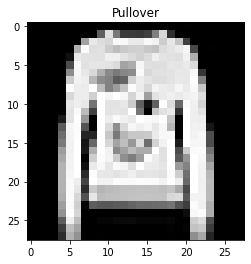

In [63]:
index = 5000

print(f'{(activation4.output[index][np.where(activation4.output[index] == np.amax(activation4.output[index]))][0]*100):.3f}% Confident True is {fashion_mnist_labels[np.where(activation4.output[index] == np.amax(activation4.output[index]))[0][0]]}. True is actually {fashion_mnist_labels[y_test[index]]}')

X_test.resize(X_test.shape[0],28,28)
image = X_test[index]
fig = plt.figure
plt.title(f'{fashion_mnist_labels[y_test[index]]}')
plt.imshow(image, cmap='gray')
plt.show()

Plotting Graphs

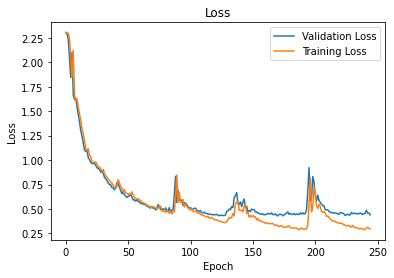

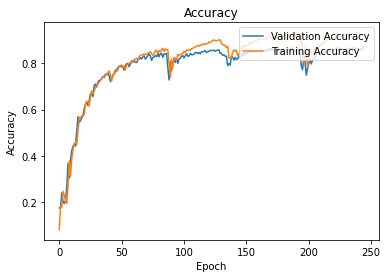

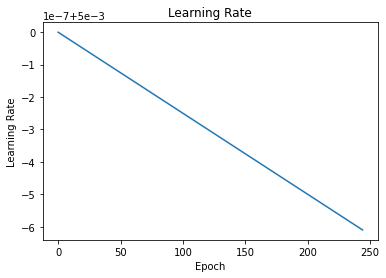

In [52]:
plt.plot(epoch_cache, val_loss_cache, label='Validation Loss')
plt.plot(epoch_cache, loss_cache, label='Training Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc = "upper right")
plt.show()

plt.plot(epoch_cache, val_acc_cache, label='Validation Accuracy')
plt.plot(epoch_cache, acc_cache, label='Training Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc = "upper right")
plt.show()

plt.plot(epoch_cache, lr_cache, label='LR')
plt.title('Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.show()